In [1]:
import sys
import argparse
import time
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np

In [318]:
## image:

pano_img = cv2.imread("./data/pano2.png")

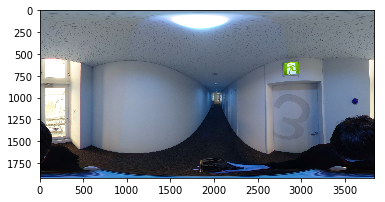

In [319]:
plt.imshow(pano_img)

In [320]:
pi = np.pi
inc = pi / 36
yaw = 0 * inc  # -pi < b < pi
pitch = 0 * inc  # -pi/2 < a < pi/2
roll = 0
rot = [yaw, pitch, roll]

fov_x = 60
pers_size = [480, 640]

## Using Pytorch

In [321]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image

In [322]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[[2, 1, 0]])
])

In [323]:
# panorama and perspective image

pano_w = pano_img.shape[1]
pano_h = pano_img.shape[0]

pers_w = pers_size[1]
pers_h = pers_size[0]

# rotation 

rot_yaw, rot_pitch, rot_roll = rot

R_pitch = [[1, 0, 0],
           [0, np.cos(rot_pitch), -np.sin(rot_pitch)],
           [0, np.sin(rot_pitch), np.cos(rot_pitch)]
          ]
R_yaw = [[np.cos(rot_yaw), 0, -np.sin(rot_yaw)],
         [0, 1, 0],
         [np.sin(rot_yaw), 0, np.cos(rot_yaw)]
        ]
R_roll = [[np.cos(rot_roll), -np.sin(rot_roll), 0],
          [np.sin(rot_roll), np.cos(rot_roll), 0],
          [0, 0, 1]
         ]
R =  torch.Tensor(R_pitch) @ torch.Tensor(R_yaw) @ torch.Tensor(R_roll)
R_inv = R.inverse()
print(R)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [324]:
## camera intrinsics

f = pers_w / (2 * np.tan(np.radians(fov_x) / 2))

K = torch.tensor([[f, 0, pers_w],
                  [0, f, pers_h],
                  [0, 0, 1]])
K_inv = K.inverse()
print(K_inv)

tensor([[ 0.0018,  0.0000, -1.1547],
        [ 0.0000,  0.0018, -0.8660],
        [ 0.0000,  0.0000,  1.0000]])


In [340]:
_vi = torch.linspace(0, pers_w - 1, pers_w)
_vj = torch.linspace(0, pers_h - 1, pers_h)

vj, vi = torch.meshgrid([_vj, _vi])
print(vj)
vk = torch.ones_like(vi)
print(vk)
coord = torch.stack((vi, vj, vk), dim=2)
coord = coord.unsqueeze(3)
print(coord.shape)

tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
        [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
        ...,
        [477., 477., 477.,  ..., 477., 477., 477.],
        [478., 478., 478.,  ..., 478., 478., 478.],
        [479., 479., 479.,  ..., 479., 479., 479.]])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
torch.Size([480, 640, 3, 1])


In [341]:
rot_coord = R_inv @ K_inv @ coord  # normilzed and rotated
print(rot_coord.shape)
print(rot_coord.squeeze(3).shape)
rot_coord = rot_coord.squeeze(3)

torch.Size([480, 640, 3, 1])
torch.Size([480, 640, 3])


In [355]:
from pprint import pprint

a = torch.atan2(rot_coord[:, :, 0], rot_coord[:, :, 2])
pprint(a[239, 319])
print(np.pi / 4)
b = torch.asin(rot_coord[:, :, 1] / torch.norm(rot_coord, dim=2))

ui = (a + np.pi) * pano_w / (2 * np.pi)
uj = (b + np.pi / 2) * pano_h / np.pi

# -1 ~ 1
norm_ui = 2 * (ui - pano_w / 2) / pano_w
norm_uj = 2 * (uj - pano_h / 2) / pano_h

grid = torch.stack((norm_ui, norm_uj), 2).unsqueeze(0)

tensor(-0.5250)
0.7853981633974483


In [346]:
pano = trans(pano_img)

pano = pano.expand(grid.size(0), -1, -1, -1)

pers = torch.nn.functional.grid_sample(pano, grid).squeeze(0)
pers = pers.permute(1, 2, 0)

pers_img = pers.numpy()[..., [2,1,0]]

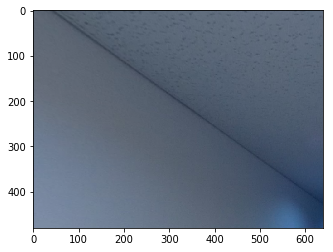

In [347]:
plt.imshow(pers_img)

In [336]:
lon = ui.numpy()
lat = uj.numpy()

pers_img2 = cv2.remap(
    pano_img,
    lon.astype(np.float32), 
    lat.astype(np.float32), 
    cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)

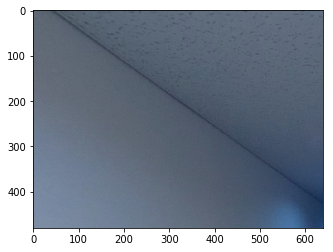

In [337]:
plt.imshow(pers_img2)

## OLD

In [303]:
RADIUS = 128
rot_yaw = 90
rot_pitch = 0

pano_cx = (pano_w - 1) / 2.0
pano_cy = (pano_h - 1) / 2.0
pers_cx = (pers_w - 1) / 2.0
pers_cy = (pers_h - 1) / 2.0

fov_w = float(60.0)
fov_h = float(pers_h) / pers_w * fov_w

angle_w = (180 - fov_w) / 2.0
len_w = 2 * RADIUS * np.sin(np.radians(fov_w / 2.0)) / np.sin(np.radians(angle_w))
interval_w = len_w / (pers_w - 1)

angle_h = (180 - fov_h) / 2.0
len_h = 2 * RADIUS * np.sin(np.radians(fov_w / 2.0)) / np.sin(np.radians(angle_h))
interval_h = len_h / (pers_h - 1)

map_x = np.zeros([pers_h, pers_w], np.float32) + RADIUS
map_y = np.tile((np.arange(0, pers_w) - pers_cx) * interval_w, [pers_h, 1])
map_z = -np.tile((np.arange(0, pers_h) - pers_cy) * interval_h, [pers_w, 1]).T

D = np.sqrt(map_x**2 + map_y**2 + map_z**2)
xyz = np.zeros([pers_h, pers_w, 3], np.float)
xyz[:, :, 0] = (RADIUS / D * map_x)[:, :]
xyz[:, :, 1] = (RADIUS / D * map_y)[:, :]
xyz[:, :, 2] = (RADIUS / D * map_z)[:, :]

In [304]:
y_axis = np.array([0.0, 1.0, 0.0], np.float32)
x_axis = np.array([1.0, 0.0, 0.0], np.float32)
[R1, _] = cv2.Rodrigues(y_axis * np.radians(rot_yaw))
[R2, _] = cv2.Rodrigues(np.dot(R1, x_axis) * np.radians(-rot_pitch))

In [305]:
xyz = xyz.reshape([pers_h * pers_w, 3]).T
xyz = np.dot(R1, xyz)
xyz = np.dot(R2, xyz).T
lat = np.arcsin(xyz[:, 2] / RADIUS)
lon = np.zeros([pers_h * pers_w], np.float)
theta = np.arctan(xyz[:, 1] / xyz[:, 0])
idx1 = xyz[:, 0] > 0
idx2 = xyz[:, 1] > 0

idx3 = ((1 - idx1) * idx2).astype(np.bool)
idx4 = ((1 - idx1) * (1 - idx2)).astype(np.bool)

lon[idx1] = theta[idx1]
lon[idx3] = theta[idx3] + np.pi
lon[idx4] = theta[idx4] - np.pi

lon = lon.reshape([pers_h, pers_w]) / np.pi * 180
lat = -lat.reshape([pers_h, pers_w]) / np.pi * 180
lon = lon / 180 * pano_cx + pano_cx
lat = lat / 90 * pano_cy + pano_cy

In [306]:
perspective = cv2.remap(
    pano_img, 
    lon.astype(np.float32), 
    lat.astype(np.float32), 
    cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)

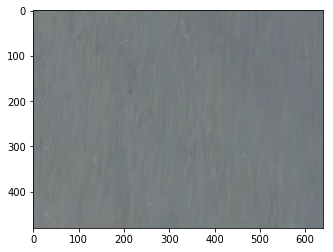

In [307]:
plt.imshow(perspective)